In [1]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.stats import uniform, randint

from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('Mixed playlist.csv')
data_df = pd.DataFrame(data)

# 1. Data exploration

Performing the data exploration to see if there is a need for:
- Eliminate records with missing-values
- Eliminate highly correlated features
- Eliminate irrelevant / useless features
- Feature scaling
- Eliminate outliers

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3591 non-null   object 
 1   album             3591 non-null   object 
 2   artist            3600 non-null   object 
 3   release_date      3600 non-null   object 
 4   length            3600 non-null   int64  
 5   popularity        3600 non-null   int64  
 6   acousticness      3600 non-null   float64
 7   danceability      3600 non-null   float64
 8   energy            3600 non-null   float64
 9   instrumentalness  3600 non-null   float64
 10  liveness          3600 non-null   float64
 11  loudness          3600 non-null   float64
 12  speechiness       3600 non-null   float64
 13  tempo             3600 non-null   float64
 14  valence           3600 non-null   float64
 15  time_signature    3600 non-null   int64  
 16  key               3600 non-null   int64  


In [4]:
data_df.describe()

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year
count,3.600000e+03,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,2.408759e+05,32.188333,0.451029,0.559205,0.503709,0.277072,0.164358,-10.720054,0.084946,115.102004,0.389938,3.866111,5.305556,0.464167,2007.343056
std,1.037588e+05,25.478877,0.358561,0.194051,0.260155,0.380640,0.141533,6.320428,0.093436,28.835005,0.256795,0.475421,3.504845,0.498784,101.071018
min,0.000000e+00,0.000000,0.000011,0.000000,0.000545,0.000000,0.017900,-42.117000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.865740e+05,0.000000,0.086675,0.429000,0.298750,0.000002,0.094100,-13.130750,0.036500,93.856500,0.163000,4.000000,2.000000,0.000000,2011.000000
50%,2.218130e+05,34.000000,0.404500,0.583000,0.528000,0.003100,0.112000,-8.879500,0.046400,114.982500,0.362000,4.000000,5.000000,0.000000,2016.000000
75%,2.699260e+05,52.000000,0.817000,0.707000,0.717000,0.718250,0.168000,-6.375500,0.086300,131.000750,0.583000,4.000000,8.000000,1.000000,2018.000000
max,1.921683e+06,91.000000,0.996000,0.971000,0.991000,0.995000,0.991000,-0.908000,0.952000,209.596000,0.981000,5.000000,11.000000,1.000000,2022.000000


In [5]:
data_df['user'].unique()

array(['unknown', 'delta', 'gamma', 'alpha', 'beta', 'epsilon'],
      dtype=object)

In [6]:
data_df['user'].value_counts().get('unknown', 0)

np.int64(100)

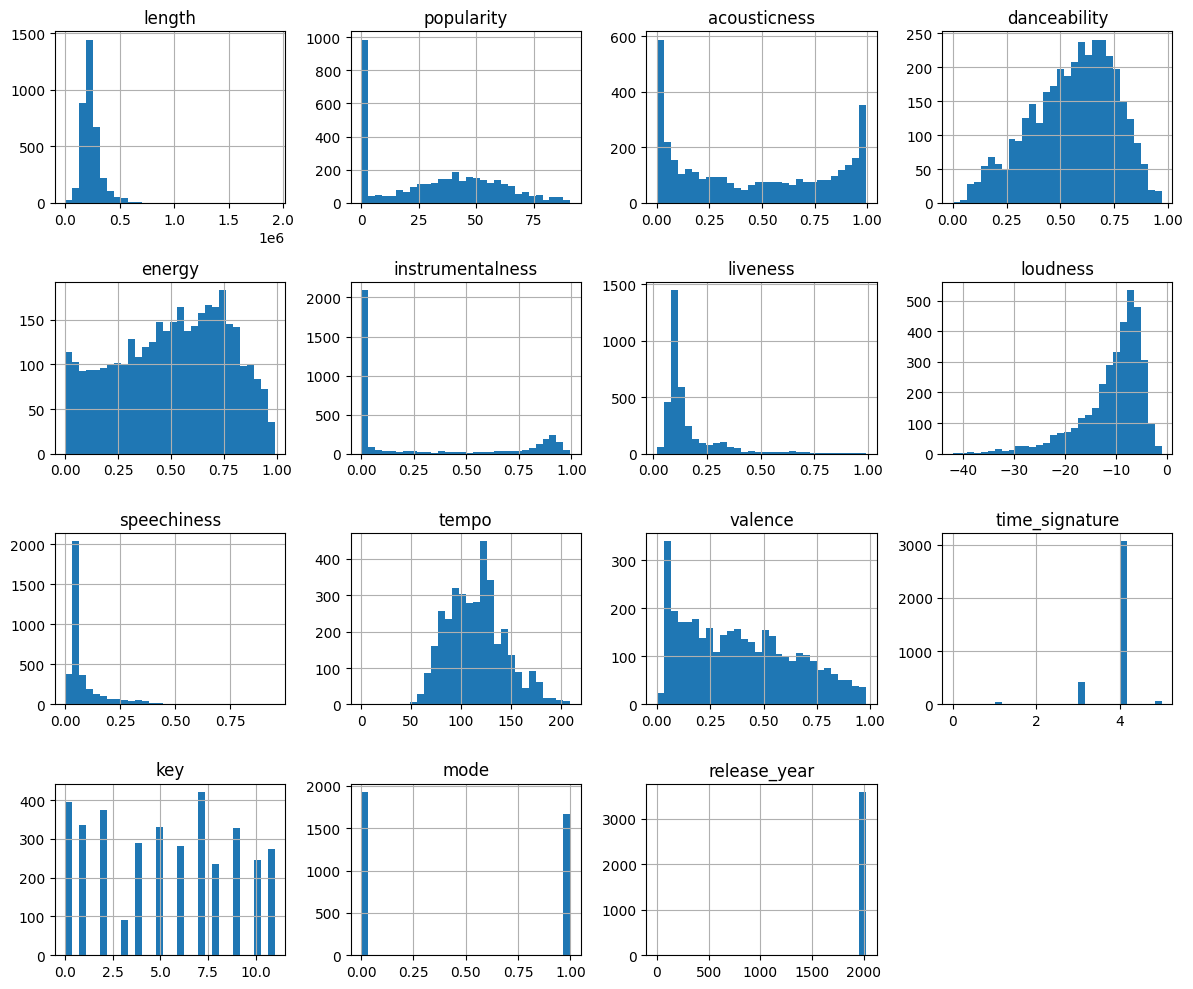

In [7]:
# Shows the histogram for all the numeric values in the data set.
data_df.hist(figsize=(12, 10),bins=30)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# display the correlation matrix between numeric variables
corr = data_df.corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm')

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year
length,1.000000,-0.084163,0.029134,-0.115441,-0.044156,0.141942,-0.008281,-0.077831,-0.018236,-0.022138,-0.181394,-0.015309,-0.031600,0.027409,0.100697
popularity,-0.084163,1.000000,-0.038865,0.054019,0.062094,-0.142565,-0.055714,0.104607,0.041965,0.031505,0.035836,-0.014869,0.001935,-0.010423,0.065753
acousticness,0.029134,-0.038865,1.000000,-0.438107,-0.784642,0.246431,-0.111100,-0.676415,-0.179138,-0.163106,-0.318691,-0.235090,-0.044212,-0.004613,-0.023982
danceability,-0.115441,0.054019,-0.438107,1.000000,0.483286,-0.374824,0.017052,0.530318,0.253741,0.101612,0.584470,0.255975,0.030394,-0.019654,0.035778
energy,-0.044156,0.062094,-0.784642,0.483286,1.000000,-0.311187,0.151676,0.827939,0.252163,0.181401,0.479323,0.242179,0.055926,-0.035017,0.068404
instrumentalness,0.141942,-0.142565,0.246431,-0.374824,-0.311187,1.000000,-0.097716,-0.482682,-0.256475,-0.055065,-0.413844,-0.135485,-0.000998,0.003616,-0.077273
liveness,-0.008281,-0.055714,-0.111100,0.017052,0.151676,-0.097716,1.000000,0.088848,0.101497,0.029610,0.119639,-0.012848,0.010227,0.014298,-0.018481
loudness,-0.077831,0.104607,-0.676415,0.530318,0.827939,-0.482682,0.088848,1.000000,0.202353,0.162616,0.465614,0.244703,0.039321,-0.015236,0.079054
speechiness,-0.018236,0.041965,-0.179138,0.253741,0.252163,-0.256475,0.101497,0.202353,1.000000,0.030258,0.250074,0.069329,0.013950,-0.034501,0.035860
tempo,-0.022138,0.031505,-0.163106,0.101612,0.181401,-0.055065,0.029610,0.162616,0.030258,1.000000,0.095698,0.014138,0.009757,-0.057142,-0.006420


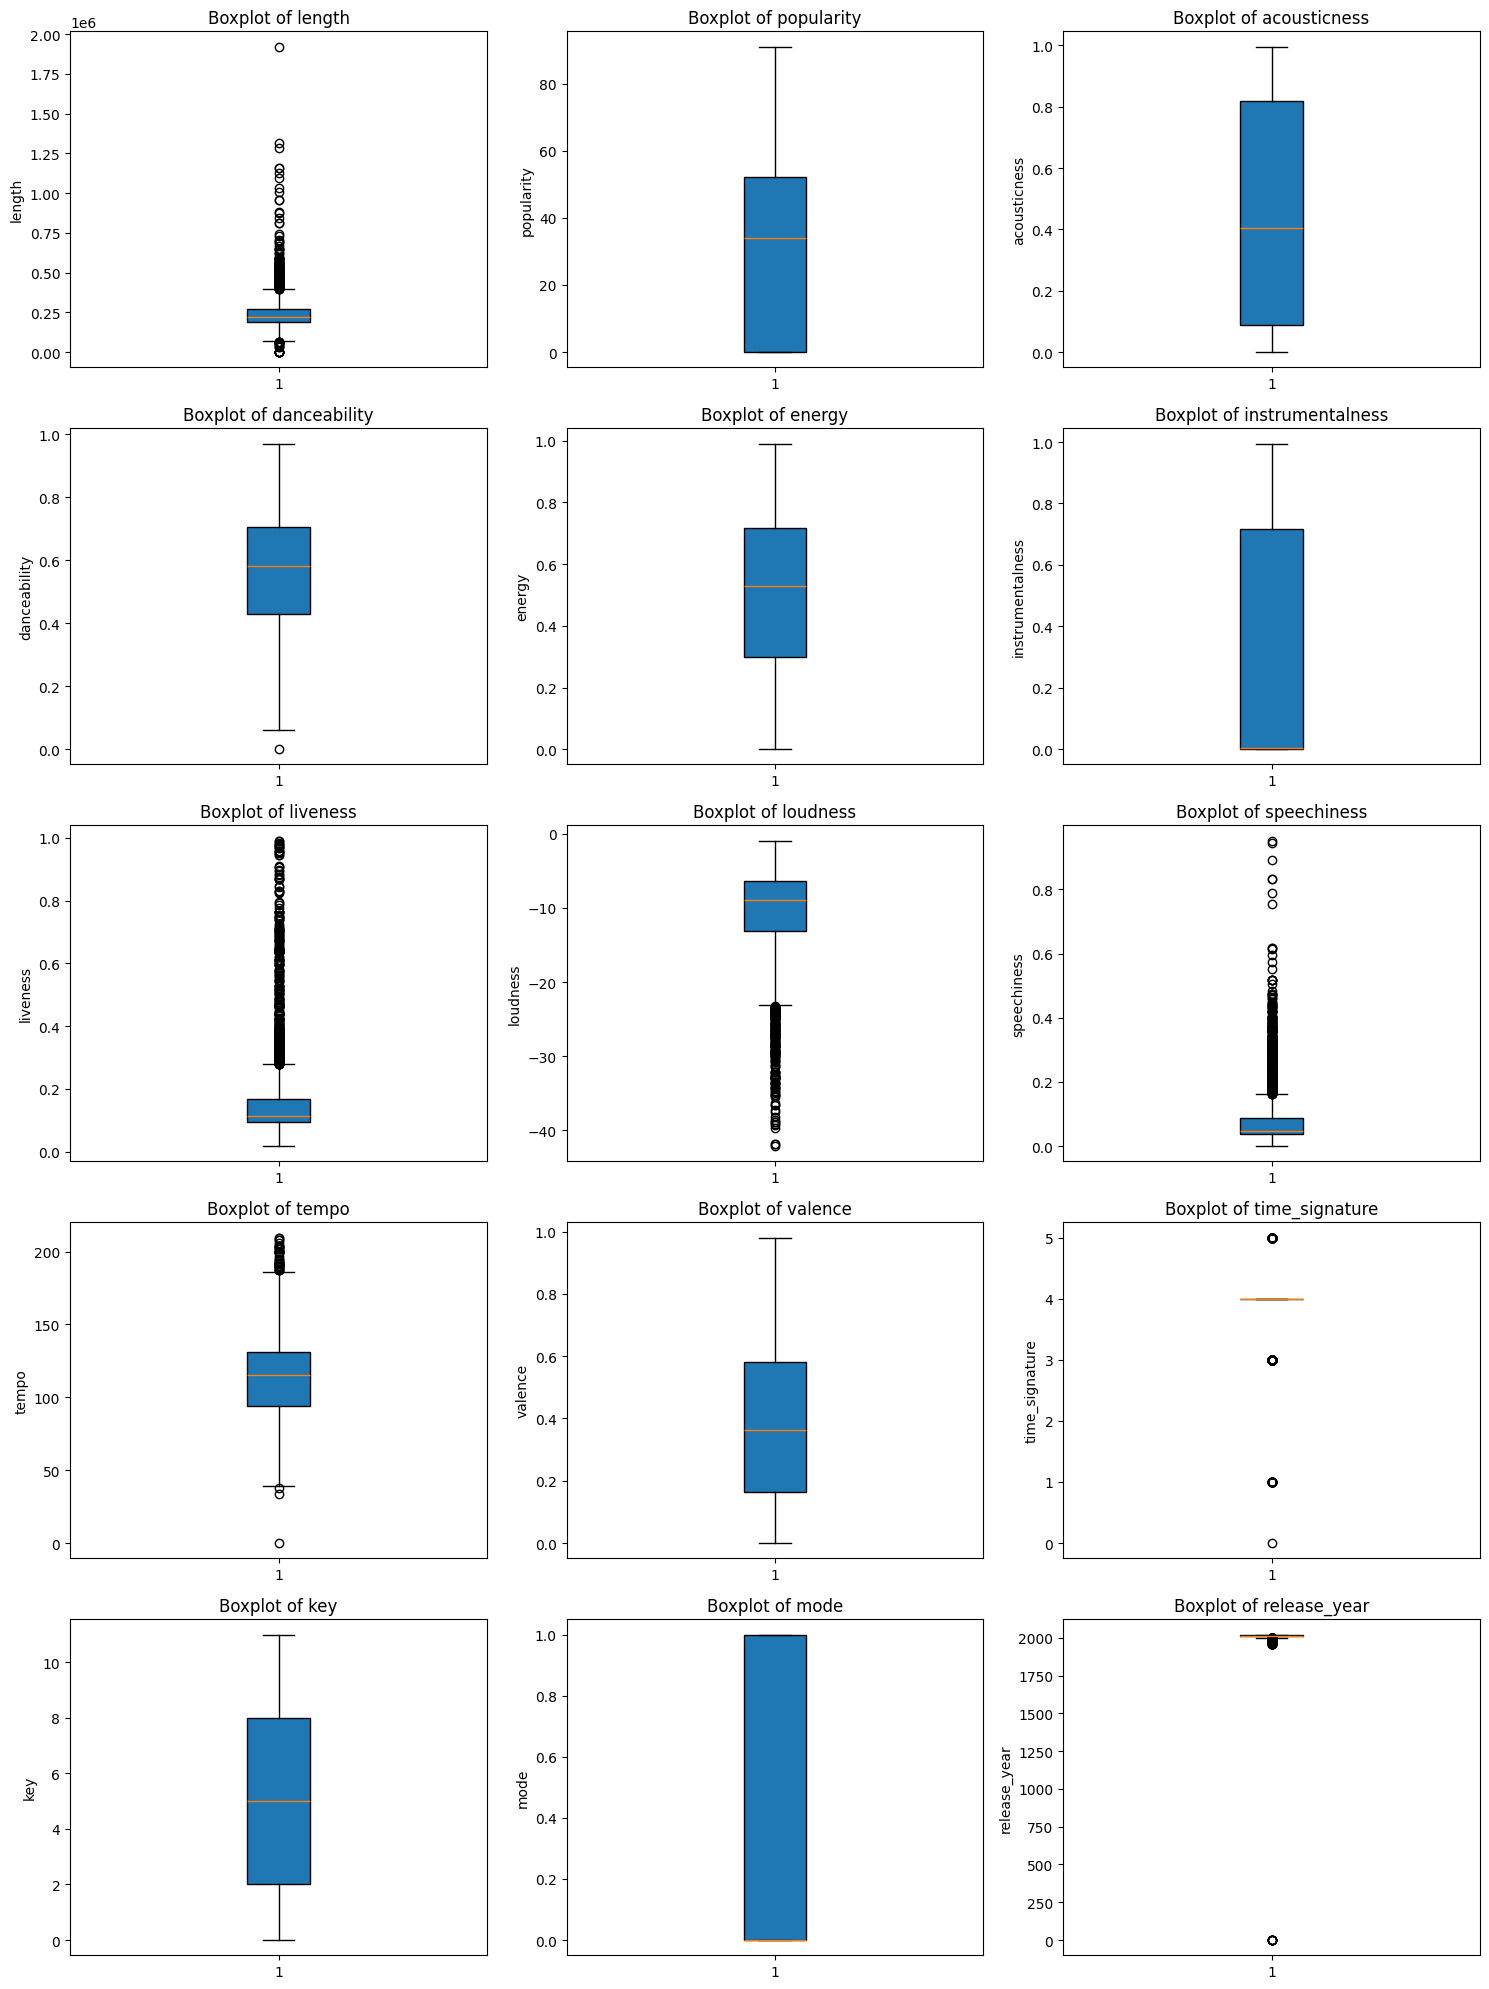

In [9]:
# Selection of only numeric columns
numeric_columns = data_df.select_dtypes(include=['float64', 'int64']).columns

# Define the number of rows and columns for subplots
n_cols = 3  # Number of columns in the figure
n_rows = -(-len(numeric_columns) // n_cols)  # Ceiling division to determine rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each numeric column and create a histogram
for idx, column in enumerate(numeric_columns):
    ax = axes[idx]
    ax.boxplot(data_df[column].dropna(), vert=True, patch_artist=True)
    ax.set_title(f"Boxplot of {column}")
    ax.set_ylabel(column)

# Hide any unused subplots
for ax in axes[len(numeric_columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Conclusions:

- Set 'unknown' users entries as test entries.
- Remove release year, uri and release date.
- Label user, top_year, name, album and artist as they are categorical columns.
- Change Top year to integrer.??
- Scale tempo, length, popularity, loudness, time_signature, key.

# 2. Data preprocessing

### Set and Label Categorical Features

In [10]:
df = data_df.copy()

categorical_cols = ['name','artist', 'album', 'top_year', 'user']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for inverse transformation later

print(label_encoders['user'].classes_)

['alpha' 'beta' 'delta' 'epsilon' 'gamma' 'unknown']


In [11]:
df['artist']

0        655
1        521
2        259
3        635
4        160
        ... 
3595    1006
3596     137
3597     680
3598      62
3599    1128
Name: artist, Length: 3600, dtype: int64

### Filtering unknown values

In [12]:
#  Count and print the number of 'unknown' values in the 'top_year' column
unknown_count = df['user'].value_counts().get(5)
print(f"Number of 'unknown' values in 'user': {unknown_count}")


Number of 'unknown' values in 'user': 100


In [13]:
# Filter rows with 'unknown' in the 'top_year' column
unknown_df = df[df['user'] == 5]

# Drop rows with 'unknown' in the 'top_year' column from the original DataFrame
df = df[df['user'] != 5]

# Display the resulting DataFrames
print("DataFrame with 'unknown' values:")
print(unknown_df.info())

DataFrame with 'unknown' values:
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 3599
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              100 non-null    int64  
 1   album             100 non-null    int64  
 2   artist            100 non-null    int64  
 3   release_date      100 non-null    object 
 4   length            100 non-null    int64  
 5   popularity        100 non-null    int64  
 6   acousticness      100 non-null    float64
 7   danceability      100 non-null    float64
 8   energy            100 non-null    float64
 9   instrumentalness  100 non-null    float64
 10  liveness          100 non-null    float64
 11  loudness          100 non-null    float64
 12  speechiness       100 non-null    float64
 13  tempo             100 non-null    float64
 14  valence           100 non-null    float64
 15  time_signature    100 non-null    int64  
 16  key            

### Remove Irrelevant Data

In [14]:
df = df.drop(columns=['uri', 'release_date', 'release_year'])

### Scale the features

MinMaxScaler is used to preserve the shape of the original distribution and scale the features between a range from 0 to 1

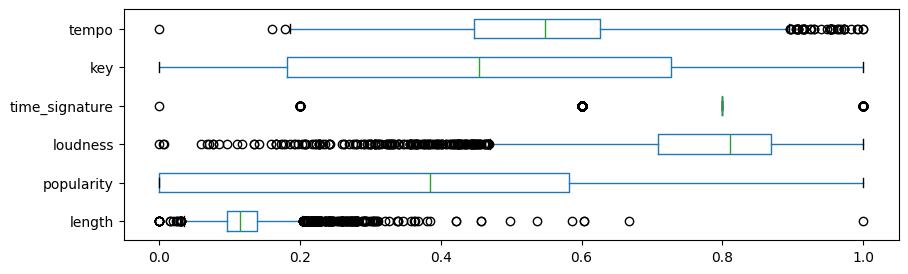

In [15]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame and it includes the selected columns
s_columns = ['length', 'popularity', 'loudness', 'time_signature', 'key','tempo']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply the MinMaxScaler to the selected columns
df[s_columns] = scaler.fit_transform(df[s_columns])

df.boxplot(
    grid=False,
    figsize=(10, 3),
    column=s_columns,
    vert=False
)
plt.show()

# 3. Application of Models

## Unsupervised model

### Clustering K-Means

We decided to used a clustering method to analyze if there is any natural cluster in the data set that could lead to some insights or ideas.

In [16]:
col_features = ['length','acousticness','danceability', 'energy','instrumentalness','liveness','valence', 'loudness','speechiness','tempo']
X = df[col_features]
model = KMeans(
    init="k-means++",
    n_clusters=5,
    random_state=15)

model.fit(X)

labeled_df = df.copy()
labeled_df['kmeans'] = model.labels_

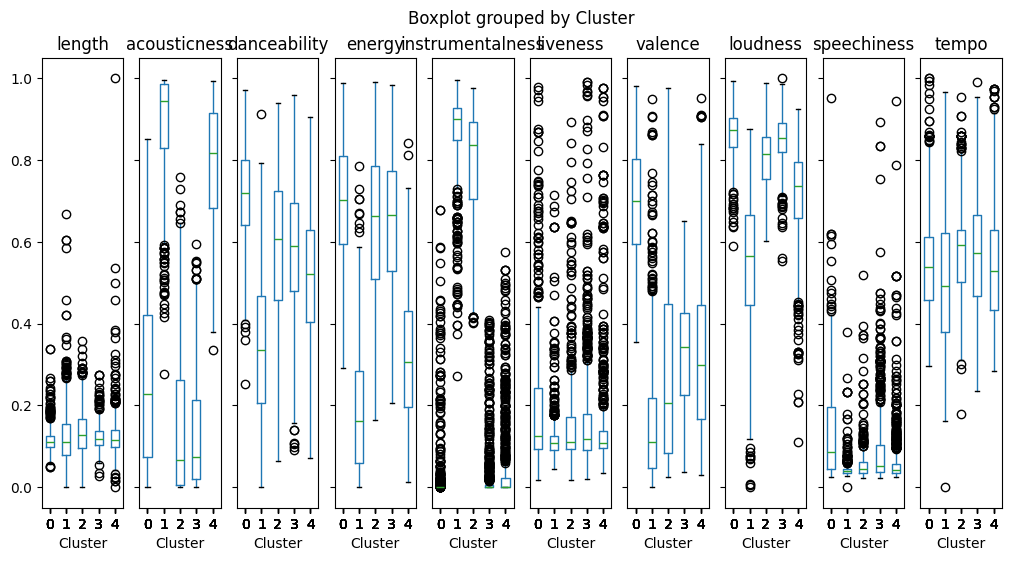

In [17]:
# display the boxplot by cluster
labeled_df = df.copy()
labeled_df['Cluster'] = model.labels_
labeled_df.boxplot(
    column = col_features,
    by = 'Cluster',
    grid = False,
    figsize = (12, 6),
    layout = (1, 10)
)
plt.show()

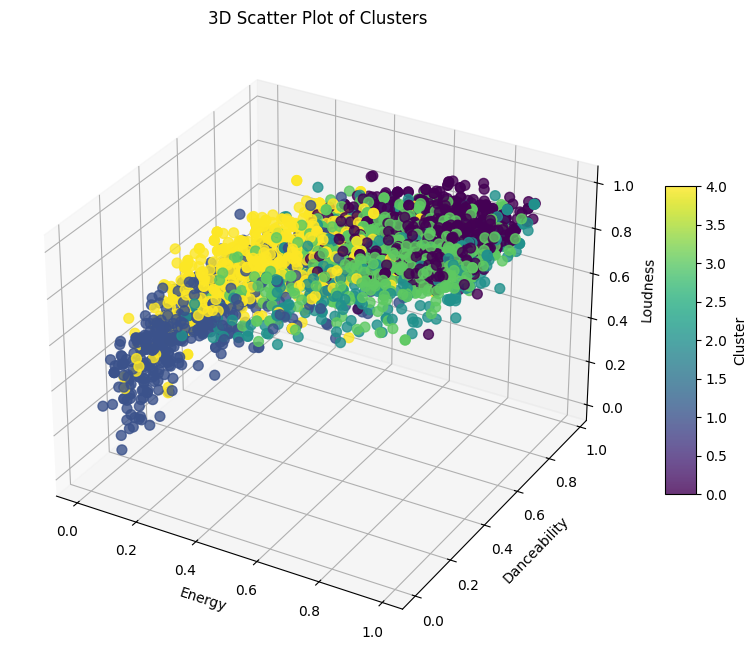

In [18]:
# Extract the columns for plotting
x = labeled_df['energy']
y = labeled_df['danceability']
z = labeled_df['loudness']
clusters = labeled_df['Cluster']

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a unique color
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', s=50, alpha=0.8)

# Add labels
ax.set_xlabel('Energy')
ax.set_ylabel('Danceability')
ax.set_zlabel('Loudness')
ax.set_title('3D Scatter Plot of Clusters')

# Add a color bar for the clusters
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Cluster')

# Show the plot
plt.show()


The results showed that there is no clear clusters per user, so the clustering methods are not useful in this case.

## Supervised models

### Random Forest Classifier

In [19]:
# Define features (X) and target (y)
target_df = df[['user']]
feature_df_rf = df.drop(['top_year','user'], axis=1) #The year is dropped as it is also a target feature.
feature_df_rf.head()

,name,album,artist,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode
1,1184,825,521,0.089831,0.681319,0.6220,0.615,0.599,0.000008,0.192,0.810551,0.2530,0.414970,0.626,0.8,0.090909,1
2,1543,1271,259,0.091206,0.791209,0.4130,0.834,0.734,0.000040,0.113,0.877697,0.3410,0.429345,0.356,0.8,0.545455,0
3,1485,1327,635,0.091204,0.000000,0.4040,0.797,0.506,0.000153,0.255,0.857652,0.0327,0.610827,0.539,0.8,0.454545,0
4,893,1922,160,0.137762,0.582418,0.0616,0.788,0.675,0.711000,0.100,0.813560,0.0318,0.515244,0.525,0.8,0.636364,0
5,2261,1522,719,0.133688,0.000000,0.4190,0.677,0.298,0.080200,0.108,0.738698,0.0501,0.683310,0.552,0.8,0.181818,0


In [20]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    feature_df_rf.values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 42
)

In [21]:
# Multi-output Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [22]:
# Predict both targets
y_pred = rf.predict(X_test)

# Evaluate for each target individually
print("User Classification Report:")
print(classification_report(y_test, y_pred))  # First target (user_encoded)

User Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47       213
           1       0.64      0.58      0.61       213
           2       0.65      0.67      0.66       219
           3       0.53      0.69      0.60       182
           4       0.67      0.73      0.70       223

    accuracy                           0.61      1050
   macro avg       0.61      0.62      0.61      1050
weighted avg       0.62      0.61      0.61      1050



### Logistic Regresion

In [23]:
relevant_features = ['length', 'popularity', 'acousticness', 'danceability', 
                  'energy', 'instrumentalness', 'liveness', 'loudness', 
                  'speechiness', 'tempo', 'valence', 'time_signature', 
                  'key', 'mode']
#Respliting
target_df = df[['user']]
y_year = df[['top_year']]
feature_df=df.drop(['top_year','user'], axis=1)

feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 1 to 3598
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3500 non-null   int64  
 1   album             3500 non-null   int64  
 2   artist            3500 non-null   int64  
 3   length            3500 non-null   float64
 4   popularity        3500 non-null   float64
 5   acousticness      3500 non-null   float64
 6   danceability      3500 non-null   float64
 7   energy            3500 non-null   float64
 8   instrumentalness  3500 non-null   float64
 9   liveness          3500 non-null   float64
 10  loudness          3500 non-null   float64
 11  speechiness       3500 non-null   float64
 12  tempo             3500 non-null   float64
 13  valence           3500 non-null   float64
 14  time_signature    3500 non-null   float64
 15  key               3500 non-null   float64
 16  mode              3500 non-null   int64  
dtype

In [24]:
# Split the dataset
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    feature_df.values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 42
)

In [25]:
# Train Logistic Regression for User Prediction
user_model = LogisticRegression(max_iter=10000)
user_model.fit(X_train_user, y_train_user)

# Evaluate User Prediction
y_pred_user = user_model.predict(X_test_user)
print("\nUser Prediction Classification Report:")
print(classification_report(y_test_user, y_pred_user))

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



User Prediction Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.26      0.30       213
           1       0.42      0.38      0.40       213
           2       0.42      0.40      0.41       219
           3       0.38      0.53      0.44       182
           4       0.45      0.49      0.47       223

    accuracy                           0.41      1050
   macro avg       0.41      0.41      0.40      1050
weighted avg       0.41      0.41      0.40      1050



/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNeighborsClassifier

In [26]:
# Train Logistic Regression for User Prediction
user_model = KNeighborsClassifier(n_neighbors=5)
user_model.fit(X_train_user, y_train_user)

# Evaluate User Prediction
y_pred_user = user_model.predict(X_test_user)
print("\nUser Prediction Classification Report:")
print(classification_report(y_test_user, y_pred_user))


User Prediction Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.37      0.33       213
           1       0.35      0.35      0.35       213
           2       0.36      0.33      0.35       219
           3       0.32      0.35      0.33       182
           4       0.37      0.29      0.32       223

    accuracy                           0.34      1050
   macro avg       0.34      0.34      0.34      1050
weighted avg       0.34      0.34      0.34      1050



/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


We try to use some models on the year target to evaluate if it is reliable

In [27]:
# Split the dataset
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
    feature_df.values,
    y_year.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 42
)

In [28]:
# Train KNN for Year Prediction
year_model = KNeighborsClassifier(n_neighbors=15)
year_model.fit(X_train_year, y_train_year)

# Evaluate Year Prediction
y_pred_year = year_model.predict(X_test_year)
print("\nYear Prediction Classification Report:")
print(classification_report(y_test_year, y_pred_year))


Year Prediction Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.21      0.18       159
           1       0.14      0.17      0.16       147
           2       0.11      0.09      0.10       150
           3       0.26      0.19      0.22       164
           4       0.23      0.25      0.24       130
           5       0.16      0.14      0.15       147
           6       0.27      0.25      0.26       153

    accuracy                           0.19      1050
   macro avg       0.19      0.19      0.19      1050
weighted avg       0.19      0.19      0.19      1050



/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


The models that try to predict the top year are no accurate, therefore it is needed to find another way to improve the reconstruction of the playlists

### Random Search Classifier 

In [29]:
# Redefine the hyper-parameters to search
param_distributions = dict(
    criterion = ['gini', 'entropy', 'log_loss'],
    max_depth = randint(low = 2, high = 20), # Probability distribution
    min_impurity_decrease = uniform(0,0.1), #uniform distribution between 0 and 1
    min_samples_split = randint(low = 2, high = 20), #The minimum number of samples required to split an internal node
    min_samples_leaf = randint(1, 10), #The minimum number of samples required to be at a leaf node.
    max_features = ['sqrt', 'log2', None] #Number of features to consider when looking for the best split
) # Add flexibility to the use of the parameters.

rand_clf = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(),
    param_distributions = param_distributions,
    n_iter = 100,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3,
    verbose = 1,
    random_state = 0, #Control the random seed.
)
rand_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16807ce30>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x157dad4f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157fc1d30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157d6c710>},
                   random_state=0, scoring='f1_weighted', verbose=1)

In [30]:
# obtain the best hyper-parameters the best score
print('Best hyper-parameters:', rand_clf.best_params_)
print('Best score:', rand_clf.best_score_)

Best hyper-parameters: {'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'min_impurity_decrease': np.float64(0.001142745862503103), 'min_samples_leaf': 4, 'min_samples_split': 14}
Best score: 0.4508255578135236


In [31]:
# predict categories for test dataset
y_pred = rand_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41       213
           1       0.48      0.42      0.45       213
           2       0.55      0.49      0.52       219
           3       0.44      0.53      0.48       182
           4       0.59      0.51      0.55       223

    accuracy                           0.48      1050
   macro avg       0.49      0.48      0.48      1050
weighted avg       0.49      0.48      0.48      1050



### K-means Pipeline

In [32]:
# [TBC] complete your code here with proper comments
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('k-nearest neighbors', KNeighborsClassifier(
            n_neighbors = 5, # consider 5 nearest neighbors
            weights = 'uniform', # all nearest neighbors are equally important
            metric = 'minkowski', # use Euclidean distance as the distance metric
        ))
    ]
)

# fit the model
clf.fit(X_train, y_train)

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Pipeline(steps=[('standard scaler', StandardScaler()),
                ('k-nearest neighbors', KNeighborsClassifier())])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41       213
           1       0.48      0.42      0.45       213
           2       0.55      0.49      0.52       219
           3       0.44      0.53      0.48       182
           4       0.59      0.51      0.55       223

    accuracy                           0.48      1050
   macro avg       0.49      0.48      0.48      1050
weighted avg       0.49      0.48      0.48      1050



### SVC Pipeline

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


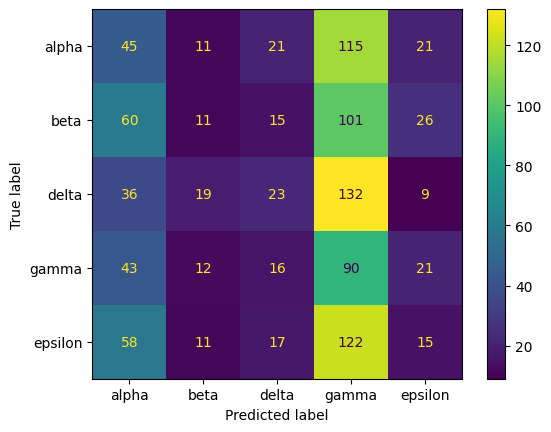

              precision    recall  f1-score   support

           0       0.19      0.21      0.20       213
           1       0.17      0.05      0.08       213
           2       0.25      0.11      0.15       219
           3       0.16      0.49      0.24       182
           4       0.16      0.07      0.10       223

    accuracy                           0.18      1050
   macro avg       0.19      0.19      0.15      1050
weighted avg       0.19      0.18      0.15      1050



In [34]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
# construct the pipeline Polynominal
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=2)),
        ('support vector machine', SVC(
            kernel = 'poly', # linear kernel function
            probability = True
        ))
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ['alpha', 'beta', 'delta', 'gamma', 'epsilon']
)
disp.plot()

plt.show()
print(classification_report(y_test, y_pred))

# 4. Reconstruction of the playlists by user

Reconstruction of the playlists with the model that had the best performance -> The Random Forest Classifier.

It is done just by the user as it had a 'better' performance, after reconstructing the user, the top_year will be reconstructed per user.

### Evaluating accuracy

In [35]:
print(X.columns)  # Verify feature columns match those used for training

Index(['length', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo'],
      dtype='object')


In [36]:
# Predict User and Year for All Songs
df['predicted_user'] = rf.predict(feature_df_rf)

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [37]:
# Calculate accuracy of user prediction
accuracy = accuracy_score(df['user'], df['predicted_user'])

# Print the result
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.88


In [38]:
# Generate a classification report
report = classification_report(df['user'], df['predicted_user'])
print(report)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       700
           1       0.89      0.87      0.88       700
           2       0.88      0.89      0.89       700
           3       0.85      0.92      0.88       700
           4       0.89      0.91      0.90       700

    accuracy                           0.88      3500
   macro avg       0.88      0.88      0.88      3500
weighted avg       0.88      0.88      0.88      3500



### Reconstruction of the unknown values

In [39]:
df.columns

Index(['name', 'album', 'artist', 'length', 'popularity', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'time_signature', 'key', 'mode',
       'top_year', 'user', 'predicted_user'],
      dtype='object')

In [40]:
needed_columns = ['name', 'album', 'artist', 'length', 'popularity', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'time_signature', 'key', 'mode',
       'top_year', 'user']

In [41]:
unknown_df = unknown_df[needed_columns]
unknown_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 3599
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              100 non-null    int64  
 1   album             100 non-null    int64  
 2   artist            100 non-null    int64  
 3   length            100 non-null    int64  
 4   popularity        100 non-null    int64  
 5   acousticness      100 non-null    float64
 6   danceability      100 non-null    float64
 7   energy            100 non-null    float64
 8   instrumentalness  100 non-null    float64
 9   liveness          100 non-null    float64
 10  loudness          100 non-null    float64
 11  speechiness       100 non-null    float64
 12  tempo             100 non-null    float64
 13  valence           100 non-null    float64
 14  time_signature    100 non-null    int64  
 15  key               100 non-null    int64  
 16  mode              100 non-null    int64  
 17  t

In [42]:
X_unknown = unknown_df[feature_df_rf.columns]
X_unknown.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 3599
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              100 non-null    int64  
 1   album             100 non-null    int64  
 2   artist            100 non-null    int64  
 3   length            100 non-null    int64  
 4   popularity        100 non-null    int64  
 5   acousticness      100 non-null    float64
 6   danceability      100 non-null    float64
 7   energy            100 non-null    float64
 8   instrumentalness  100 non-null    float64
 9   liveness          100 non-null    float64
 10  loudness          100 non-null    float64
 11  speechiness       100 non-null    float64
 12  tempo             100 non-null    float64
 13  valence           100 non-null    float64
 14  time_signature    100 non-null    int64  
 15  key               100 non-null    int64  
 16  mode              100 non-null    int64  
dtypes

In [43]:
# Predict the user for the unknown rows
unknown_df['predicted_user'] = rf.predict(X_unknown)

/Users/germanesteban/Library/Mobile Documents/com~apple~CloudDocs/Documents/Master Data Analitics/Machine Learning/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [44]:
print(unknown_df[['user','predicted_user']])

      user  predicted_user
0        5               1
66       5               1
71       5               1
83       5               0
138      5               2
...    ...             ...
3364     5               2
3439     5               2
3473     5               1
3513     5               1
3599     5               4

[100 rows x 2 columns]


In [45]:
# Ensure the unknown_df contains the necessary columns and predictions
unknown_df['user'] = unknown_df['predicted_user']  # Change the predicted_user to the user column for the unknown values

# Append the predictions as new rows to the original DataFrame
final_df = pd.concat([df, unknown_df], ignore_index=True)

# Display the updated DataFrame
print(final_df.tail())

      name  album  artist    length  popularity  acousticness  danceability  \
3595   458    855    1081  160826.0        34.0         0.960         0.443   
3596  2574    678     447  165626.0        32.0         0.996         0.912   
3597    31   1560     223  175680.0        36.0         0.982         0.146   
3598  1828   1797    1221  150000.0         0.0         0.984         0.157   
3599  2142   1518    1128  229626.0        33.0         0.161         0.724   

      energy  instrumentalness  liveness  loudness  speechiness    tempo  \
3595  0.1290           0.91700    0.1100   -19.718       0.0516  117.938   
3596  0.3480           0.74100    0.1150   -13.155       0.0572  117.872   
3597  0.0527           0.93300    0.0748   -26.554       0.0401   76.216   
3598  0.2540           0.06610    0.2760   -15.410       0.0394  156.875   
3599  0.7360           0.00444    0.1620    -6.525       0.0455  118.989   

      valence  time_signature  key  mode  top_year  user  predicted_

## 5. Re-running the model per user to predict the top_year

### Creation of dictionaries

In [46]:
final_df[['top_year','user']].tail()

,top_year,user
3595,7,2
3596,7,2
3597,7,1
3598,7,1
3599,7,4


In [47]:
# Filter rows with known 'top_year' (excluding 'unknown') and group by user
user_dfs = {}
for user in final_df['user'].unique():
    user_df = final_df[(final_df['user'] == user) & (final_df['top_year'] != 7)]
    if not user_df.empty:  # Only add users with known years
        user_dfs[user] = user_df

# Verify the result
for user, df in user_dfs.items():
    print(f"User {user} has {len(df)} rows with known 'top_year'")

User 2 has 700 rows with known 'top_year'
User 4 has 700 rows with known 'top_year'
User 0 has 700 rows with known 'top_year'
User 1 has 700 rows with known 'top_year'
User 3 has 700 rows with known 'top_year'


In [48]:
# Filter rows where 'top_year' is 'unknown' and group by user
unknown_year_dfs = {}
for user in final_df['user'].unique():
    unknown_df = final_df[(final_df['user'] == user) & (final_df['top_year'] == 7)]
    if not unknown_df.empty:  # Only add users with unknown years
        unknown_year_dfs[user] = unknown_df

# Verify the result
for user, df in unknown_year_dfs.items():
    print(f"User {user} has {len(df)} rows with unknown 'top_year'")

User 2 has 20 rows with unknown 'top_year'
User 4 has 28 rows with unknown 'top_year'
User 0 has 15 rows with unknown 'top_year'
User 1 has 33 rows with unknown 'top_year'
User 3 has 4 rows with unknown 'top_year'


### Applying the Random Forest Model on each user

In [49]:
rf_models = {}  # Store trained RF models
predictions = {}
evaluation_scores = {}  # Store evaluation metrics per user

feature_columns = ['name', 'album', 'artist', 'length', 'popularity', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'time_signature', 'key', 'mode']

for user, df_train in user_dfs.items():
    print(f"Training Random Forest model for User: {user}")

    # Prepare training data
    X = df_train[feature_columns]
    y = df_train['top_year']
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train Random Forest model
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    rf_models[user] = rf  # Save the model
    
    # Evaluate the model
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    # Store evaluation metrics
    evaluation_scores[user] = {'accuracy': accuracy, 'report': report}

# Summary of evaluation scores
print("\nSummary of Evaluation Scores:")
for user, metrics in evaluation_scores.items():
    print(f"User {user} - Accuracy: {metrics['accuracy']:.4f}")

Training Random Forest model for User: 2
Training Random Forest model for User: 4
Training Random Forest model for User: 0
Training Random Forest model for User: 1
Training Random Forest model for User: 3

Summary of Evaluation Scores:
User 2 - Accuracy: 0.3095
User 4 - Accuracy: 0.2238
User 0 - Accuracy: 0.3952
User 1 - Accuracy: 0.4429
User 3 - Accuracy: 0.3571


### Predicting the unknown values

In [50]:
for user, df_train in user_dfs.items():
    if user in unknown_year_dfs:
        print(f"Predicting 'top_year' for User: {user}")
        X_unknown = unknown_year_dfs[user][feature_columns]
        unknown_year_dfs[user].loc[:,'predicted_top_year'] = rf.predict(X_unknown)

        # Store predictions
        predictions[user] = unknown_year_dfs[user]
# Check unique values in predicted_top_year
    print("Unique predicted values:", predictions[user]['predicted_top_year'].unique())

Predicting 'top_year' for User: 2
Unique predicted values: [5 3 4]
Predicting 'top_year' for User: 4
Unique predicted values: [5 1 3 4 0]
Predicting 'top_year' for User: 0
Unique predicted values: [5 3 2 4]
Predicting 'top_year' for User: 1
Unique predicted values: [5 4 6 3 1]
Predicting 'top_year' for User: 3
Unique predicted values: [5 6 4]


/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_81885/2483351028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_year_dfs[user].loc[:,'predicted_top_year'] = rf.predict(X_unknown)
/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_81885/2483351028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_year_dfs[user].loc[:,'predicted_top_year'] = rf.predict(X_unknown)
/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_81885/2483351028.py:5: SettingWithCopyWarning: 

In [51]:
#Checking the predictions

# Replace 'user_id' with the user you want to inspect, e.g., 2
user_id = 1

# Check the rows where predictions were made for this user
predicted_df = unknown_year_dfs[user_id]
print(f"Predictions for User {user_id}:")
print(predicted_df[['name', 'album', 'artist', 'top_year', 'predicted_top_year']].head(10))

Predictions for User 1:
      name  album  artist  top_year  predicted_top_year
3500  2624   1677     655         7                   5
3501   797    174    1337         7                   5
3502   460    684     503         7                   5
3506   412   2076     218         7                   5
3511  1337   1101     970         7                   5
3513   886   1612     291         7                   4
3519   869   1441     950         7                   5
3527   288   1101     970         7                   5
3528   364   1273     617         7                   5
3537  2191   1190     356         7                   4


### Updating the Original DataFrame and Decoding the categorical Data

In [52]:
print("Unique values in predicted_top_year before decoding:")
print(predicted_df['predicted_top_year'].unique())

Unique values in predicted_top_year before decoding:
[5 4 6 3 1]


In [53]:
for user, predicted_df in predictions.items():
    # Ensure predicted_df is a copy to avoid SettingWithCopyWarning
    predicted_df = predicted_df.copy()
    
    # Update the original DataFrame
    final_df.loc[predicted_df.index, 'top_year'] = predicted_df['predicted_top_year']

# Decode other categorical columns back to their original labels
final_df['user'] = label_encoders['user'].inverse_transform(final_df['user'])
final_df['name'] = label_encoders['name'].inverse_transform(final_df['name'])
final_df['artist'] = label_encoders['artist'].inverse_transform(final_df['artist'])
final_df['album'] = label_encoders['album'].inverse_transform(final_df['album'])
final_df['top_year'] = label_encoders['top_year'].inverse_transform(final_df['top_year'])

print("Unique values in final_df['top_year'] after decoding:")
print(final_df['top_year'].unique())

Unique values in final_df['top_year'] after decoding:
['2024' '2022' '2020' '2021' '2023' '2019' '2018']


### Saving the playlists grouped by 'user' and 'top_year' as separate CSV files.

In [54]:
output_folder = "reconstructed_playlists"

os.makedirs(output_folder, exist_ok=True)

for (user, year), group in final_df.groupby(['user', 'top_year']):
    filename = os.path.join(output_folder, f"user_{user}_year_{year}.csv")
    group.to_csv(filename, index=False)
    print(f"Saved playlist for User '{user}' and Year '{year}' to {filename}")

Saved playlist for User 'alpha' and Year '2018' to reconstructed_playlists/user_alpha_year_2018.csv
Saved playlist for User 'alpha' and Year '2019' to reconstructed_playlists/user_alpha_year_2019.csv
Saved playlist for User 'alpha' and Year '2020' to reconstructed_playlists/user_alpha_year_2020.csv
Saved playlist for User 'alpha' and Year '2021' to reconstructed_playlists/user_alpha_year_2021.csv
Saved playlist for User 'alpha' and Year '2022' to reconstructed_playlists/user_alpha_year_2022.csv
Saved playlist for User 'alpha' and Year '2023' to reconstructed_playlists/user_alpha_year_2023.csv
Saved playlist for User 'alpha' and Year '2024' to reconstructed_playlists/user_alpha_year_2024.csv
Saved playlist for User 'beta' and Year '2018' to reconstructed_playlists/user_beta_year_2018.csv
Saved playlist for User 'beta' and Year '2019' to reconstructed_playlists/user_beta_year_2019.csv
Saved playlist for User 'beta' and Year '2020' to reconstructed_playlists/user_beta_year_2020.csv
Saved 

## 6. Recommendation Algorithm

### Approach 1. Random Forest Classification

In [57]:
label_encoder = LabelEncoder()
final_df['song_label'] = label_encoder.fit_transform(final_df['name'])  

# Selecting features
features = ['danceability', 'energy', 'loudness', 'popularity', 'tempo', 
            'acousticness', 'instrumentalness', 'speechiness', 'valence']
X = final_df[features]  
y = final_df['song_label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Using user_profiles
user_profiles = final_df.groupby('user').agg({
    'danceability': 'mean',
    'energy': 'mean',
    'loudness': 'mean',
    'popularity': 'mean',
    'tempo': 'mean',
    'acousticness': 'mean',
    'instrumentalness': 'mean',
    'speechiness': 'mean',
    'valence': 'mean',
}).reset_index()

# Predicting one song for each user based on their profile
user_predictions = {}

for _, user_profile in user_profiles.iterrows():
    # Extracting the user's profile features
    user_features = user_profile[features].values.reshape(1, -1)
    user_features_df = pd.DataFrame(user_features, columns=features)
    
    # Predicting the song label for the user profile
    predicted_label = rf_model.predict(user_features_df)
    predicted_song = label_encoder.inverse_transform(predicted_label)
    user_predictions[user_profile['user']] = predicted_song[0]

for user, predicted_song in user_predictions.items():
    print(f"User {user} is predicted to listen to: {predicted_song}")

User alpha is predicted to listen to: We Don't Talk About Bruno
User beta is predicted to listen to: Junk Funk - Live
User delta is predicted to listen to: Armando's Rhumba
User epsilon is predicted to listen to: Le sud
User gamma is predicted to listen to: Angela


### Approach 2. Similarity Score

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_with_profiles(df, user_profile, user_features):
    song_features = df[user_features].values  # Convert to NumPy array
    
    # Cosine similarity between the user's profile and all songs
    similarity_scores = cosine_similarity(song_features, user_profile)  # Ensure user_profile is 2D
    
    # Add similarity score to the song DataFrame
    df = df.copy()
    df['similarity_score'] = similarity_scores.flatten()
    return df

def personalized_top_tracks_with_profiles(df, user_profiles):
    top_tracks = {}
    user_features = ['danceability', 'energy', 'loudness', 'popularity', 
                     'tempo', 'acousticness', 'instrumentalness', 'speechiness', 'valence']
    
    for _, user_profile in user_profiles.iterrows():
        # Creating a user profile for similarity calculation
        user_profile_values = user_profile[user_features].values.reshape(1, -1)
        user_df = df[df['user'] == user_profile['user']]
        
        # Claculating similarity scores between each song and the user's profile
        user_df_with_similarity = calculate_similarity_with_profiles(user_df, user_profile_values, user_features)
        
        # Sorting the songs by similarity score
        user_df_sorted = user_df_with_similarity.sort_values(by='similarity_score', ascending=False)
        
        # The top 3 songs
        user_df_sorted['rank'] = user_df_sorted['similarity_score'].rank(ascending=False, method='min')
        user_df_sorted['rank'] = user_df_sorted['rank'].astype(int)
        top_tracks[user_profile['user']] = user_df_sorted.head(3)
    
    return top_tracks

# Using user profiles
user_profiles = final_df.groupby('user').agg({
    'danceability': 'mean',
    'energy': 'mean',
    'loudness': 'mean',
    'popularity': 'mean',
    'tempo': 'mean',
    'acousticness': 'mean',
    'instrumentalness': 'mean',
    'speechiness': 'mean',
    'valence': 'mean',
}).reset_index()

# Get personalized top tracks for each user
top_tracks = personalized_top_tracks_with_profiles(final_df, user_profiles)

# Displaying the results for each user
for user, user_top_tracks in top_tracks.items():
    print(f"\nNext proposed song for {user}:")
    print(user_top_tracks[['rank', 'name', 'artist', 'similarity_score']].to_string(index=False))



Next proposed song for alpha:
 rank                                   name           artist  similarity_score
    1             Why Can't We Live Together  Various Artists          0.928674
    2                     Ningu√©m, Ningu√©m    Melody Gardot          0.922734
    3 Il Pleure (At The Turn Of The Century) The Art Of Noise          0.921914

Next proposed song for beta:
 rank                name         artist  similarity_score
    1 Le jardin des F√©es    Paolo Fresu          0.977215
    2               Neige Airelle Besson          0.976758
    3  I Have Been In You    Frank Zappa          0.976448

Next proposed song for delta:
 rank                                  name        artist  similarity_score
    1                       Shhh / Peaceful   Miles Davis          0.959554
    2 "Mannix - From ""Mannix"" Soundtrack" Lalo Schifrin          0.958749
    3                     Children¬¥s World  Maceo Parker          0.958656

Next proposed song for epsilon:
 rank          